# Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import lazypredict
from matplotlib.ticker import PercentFormatter

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn import svm
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_curve, roc_auc_score,accuracy_score,make_scorer
from sklearn.metrics import recall_score,classification_report,precision_score,confusion_matrix



## Loading the Dataset

In [4]:
df = pd.read_csv('customer churn prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data Cleaning

In [5]:
df=df.drop('customer_id',axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [7]:
def report(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []
    
    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
    
    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques})
report(df)

,Column,d_type,unique_sample,n_uniques
0,credit_score,int64,"[619, 608, 502, 699, 850]",460
1,country,object,"[France, Spain, Germany]",3
2,gender,object,"[Female, Male]",2
3,age,int64,"[42, 41, 39, 43, 44]",70
4,tenure,int64,"[2, 1, 8, 7, 4]",11
5,balance,float64,"[0.0, 83807.86, 159660.8, 125510.82, 113755.78]",6382
6,products_number,int64,"[1, 3, 2, 4]",4
7,credit_card,int64,"[1, 0]",2
8,active_member,int64,"[1, 0]",2
9,estimated_salary,float64,"[101348.88, 112542.58, 113931.57, 93826.63, 79...",9999


# Exploratory Data Analysis 

In [14]:
class Dummy_Transformer(object):
    
    def fit(self, X, y=None):
        self.keys = set(X)
    
    def transform(self, X, y=None):
        result = {}
        for key in self.keys:
            result[key] = [0]*len(X)    
        for i, item in enumerate(X):
            if item in self.keys:
                result[item][i] = 1
        return pd.DataFrame(result)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)  
dummytf = Dummy_Transformer()

In [16]:
frames = [df,dummytf.fit_transform(df.country)]
dfNew=pd.concat(frames,axis=1,join='inner')
dfNew["gender"] = LabelEncoder().fit_transform(dfNew["gender"])
columns = list(dfNew)
columns.insert(900, columns.pop(columns.index('churn')))
dfNew = dfNew.loc[:, columns]

dfNum=dfNew.drop('country',axis=1)
dfNum

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,Germany,Spain,France,churn
0,619,0,42,2,0.00,1,1,1,101348.88,0,0,1,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0,1,0,0
2,502,0,42,8,159660.80,3,1,0,113931.57,0,0,1,1
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,1,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,2,1,0,96270.64,0,0,1,0
9996,516,1,35,10,57369.61,1,1,1,101699.77,0,0,1,0
9997,709,0,36,7,0.00,1,0,1,42085.58,0,0,1,1
9998,772,1,42,3,75075.31,2,1,0,92888.52,1,0,0,1


In [10]:
train_corr = dfNum.corr(method = 'pearson')
mask = np.zeros_like(train_corr)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

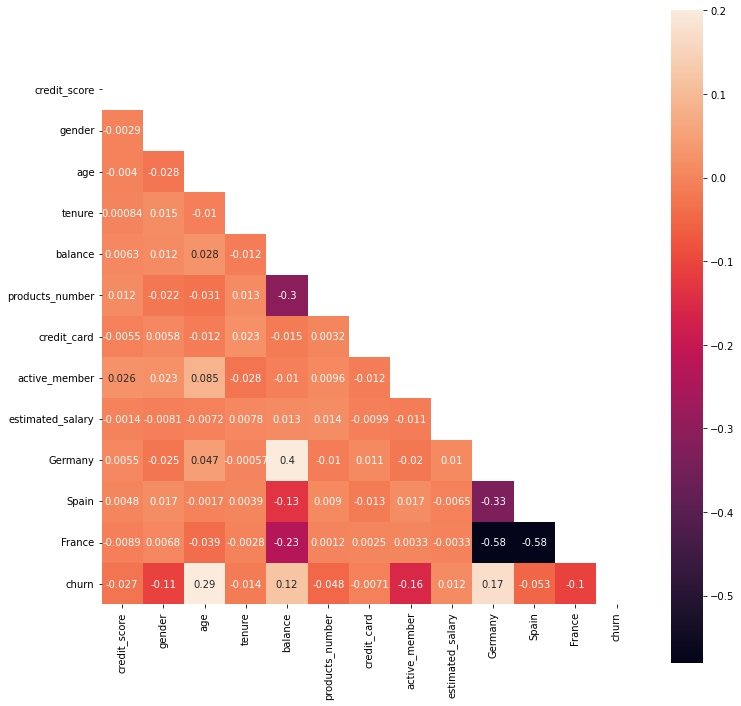

In [11]:
plt.figure(figsize=(12,12))
corrHeat = sns.heatmap(train_corr, mask=mask, annot=True,vmax=.2, square=True)
corrHeat

### Churn distribution

Churn: 2037
Retention: 7963


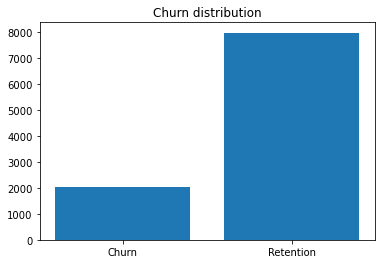

In [12]:
plt.bar(['Churn', 'Retention'], [dfNum['churn'].sum(), dfNum['churn'].shape[0]-dfNum['churn'].sum().sum()])
plt.title('Churn distribution')
print("Churn:",dfNum['churn'].sum())
print("Retention:",dfNum['churn'].shape[0]-dfNum['churn'].sum().sum())

### Country vs Churn

<AxesSubplot:title={'center':'Countries'}>

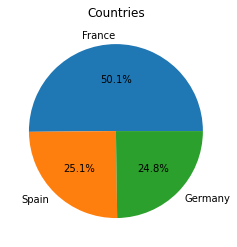

In [13]:
pd.crosstab(index=df.country,columns='count',normalize=True).plot(
    kind='pie',autopct='%.1f%%',y='count',
    labels=df.country.unique(),
    ylabel='',title='Countries',legend=False)

In [14]:
by_country = df.groupby(['country'])['churn'].value_counts(normalize=True).to_frame().rename(columns={'churn': 'ratio'}).reset_index().sort_values('country')
by_country

,country,churn,ratio
0,France,0,0.84
1,France,1,0.16
2,Germany,0,0.68
3,Germany,1,0.32
4,Spain,0,0.83
5,Spain,1,0.17


[Text(0.5, 1.0, 'Churned Probability with country')]

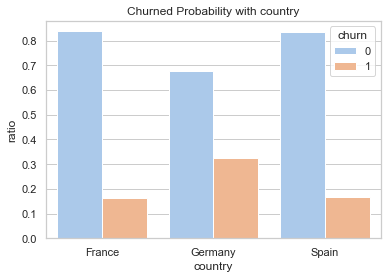

In [15]:
sns.set_theme(style="whitegrid", color_codes=True,context='notebook',palette='pastel')
sns.barplot(x='country',y='ratio', hue='churn', data=by_country).set(title = 'Churned Probability with country')

### Gender vs Churn

In [16]:
by_gender = df.groupby(['gender'])['churn'].value_counts(normalize=True).to_frame().rename(columns={'churn': 'ratio'}).reset_index().sort_values('gender')
by_gender

,gender,churn,ratio
0,Female,0,0.75
1,Female,1,0.25
2,Male,0,0.84
3,Male,1,0.16


[Text(0.5, 1.0, 'Churned Probability with gender')]

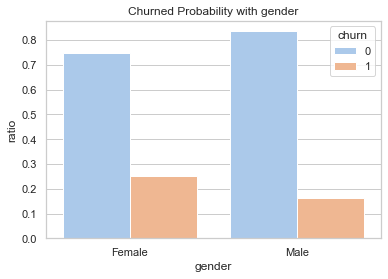

In [17]:
sns.set_theme(style="whitegrid", color_codes=True,context='notebook',palette='pastel')
sns.barplot(x='gender',y='ratio', hue='churn', data=by_gender).set(title = 'Churned Probability with gender')

### Customer age distribution vs Churn

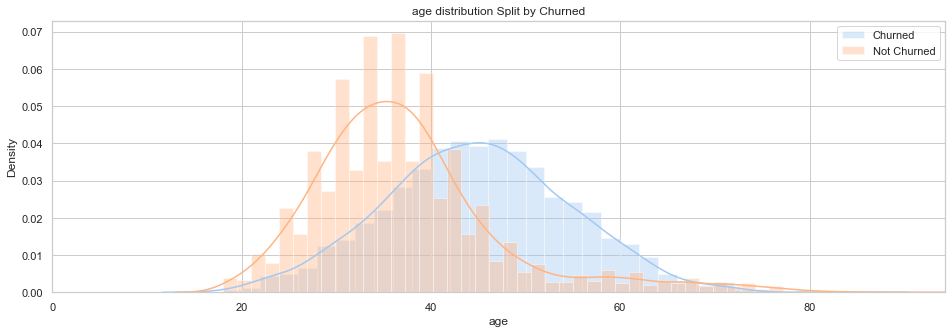

In [18]:
plt.figure(figsize=(16,5))
plt.title('age distribution Split by Churned')
sns.distplot(df[(df['churn'] == 1)]['age'], label='Churned').set(xlim=(0))
sns.distplot(df[(df['churn'] == 0)]['age'], label='Not Churned').set(xlim=(0))
plt.legend(loc= 'upper right')
plt.show()

In [19]:
by_age = df.groupby(['age'])['churn'].value_counts(normalize=True).to_frame().rename(columns={'churn': 'ratio'}).reset_index().sort_values('age')
by_age


,age,churn,ratio
0,18,0,0.91
1,18,1,0.09
2,19,0,0.96
3,19,1,0.04
4,20,0,0.95
...,...,...,...
123,84,0,0.50
124,84,1,0.50
125,85,0,1.00
126,88,0,1.00


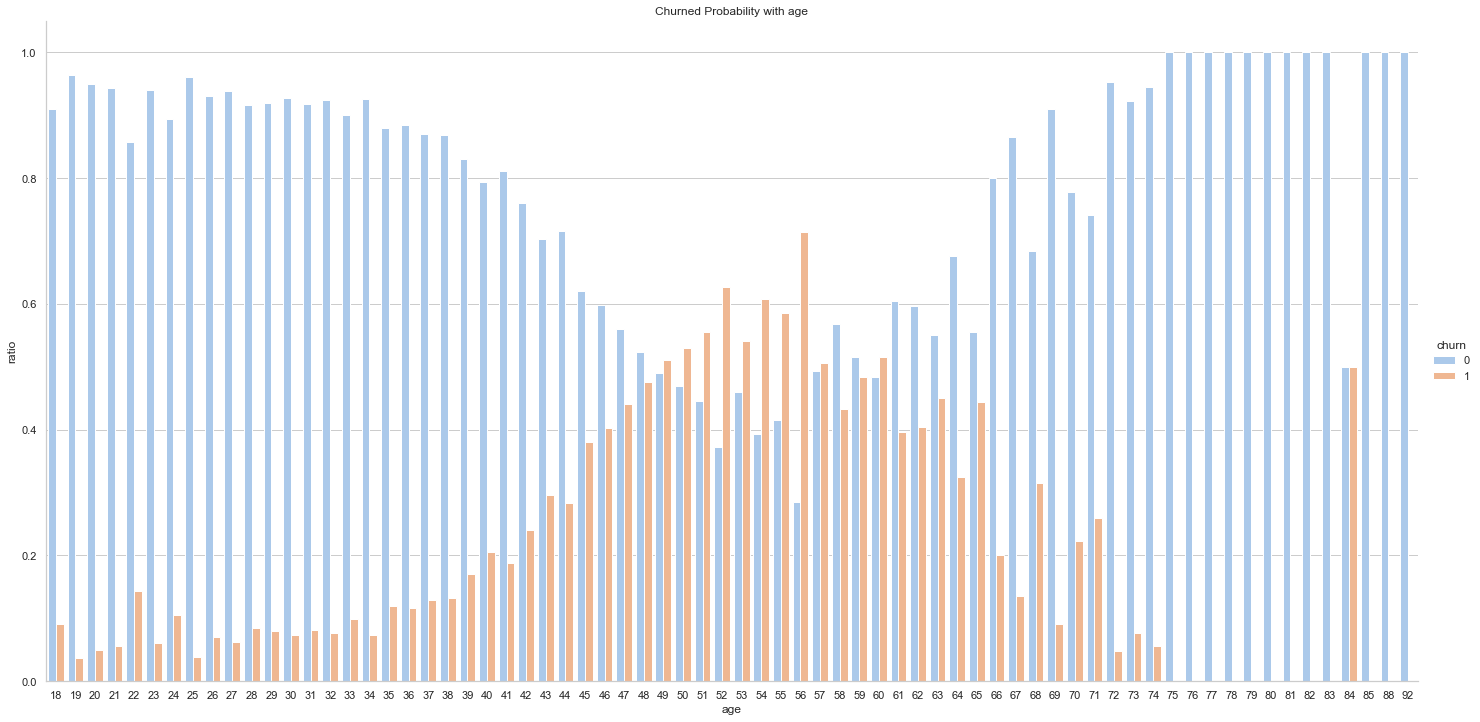

In [20]:
sns.set_theme(style="whitegrid", color_codes=True,context='notebook',palette='pastel')
sns.catplot(x='age',y='ratio', hue='churn',  kind='bar', data=by_age,height=10,aspect=2).set(title = 'Churned Probability with age')

### Active Members vs Churn

In [21]:
by_active_member = df.groupby(['active_member'])['churn'].value_counts(normalize=True).to_frame().rename(columns={'churn': 'ratio'}).reset_index().sort_values('active_member')
by_active_member


,active_member,churn,ratio
0,0,0,0.73
1,0,1,0.27
2,1,0,0.86
3,1,1,0.14


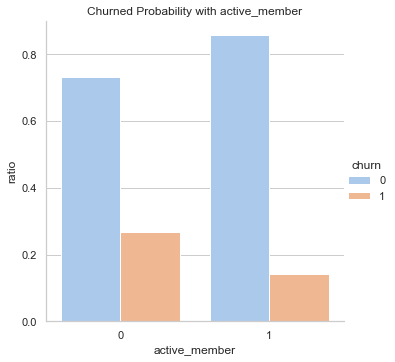

In [22]:
sns.set_theme(style="whitegrid", color_codes=True,context='notebook',palette='pastel')
sns.catplot(x='active_member',y='ratio', hue='churn',  kind='bar', data=by_active_member).set(title = 'Churned Probability with active_member')

### Tenure vs Churn

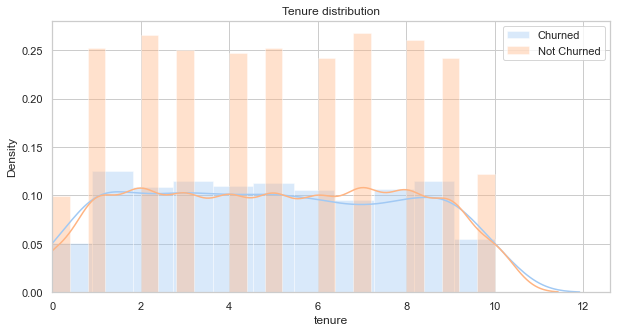

In [23]:
plt.figure(figsize=(10,5))
plt.title('Tenure distribution')
sns.distplot(df[df['churn'] == 1]['tenure'], label='Churned',hist=True, kde=True).set(xlim=(0))
sns.distplot(df[df['churn'] == 0]['tenure'], label='Not Churned',hist=True, kde=True).set(xlim=(0))
plt.legend(loc= 'upper right')
plt.show()

### Age,Credit_score,Products_number,Credit_card,Balance, vs Churn

<Figure size 1440x1080 with 0 Axes>

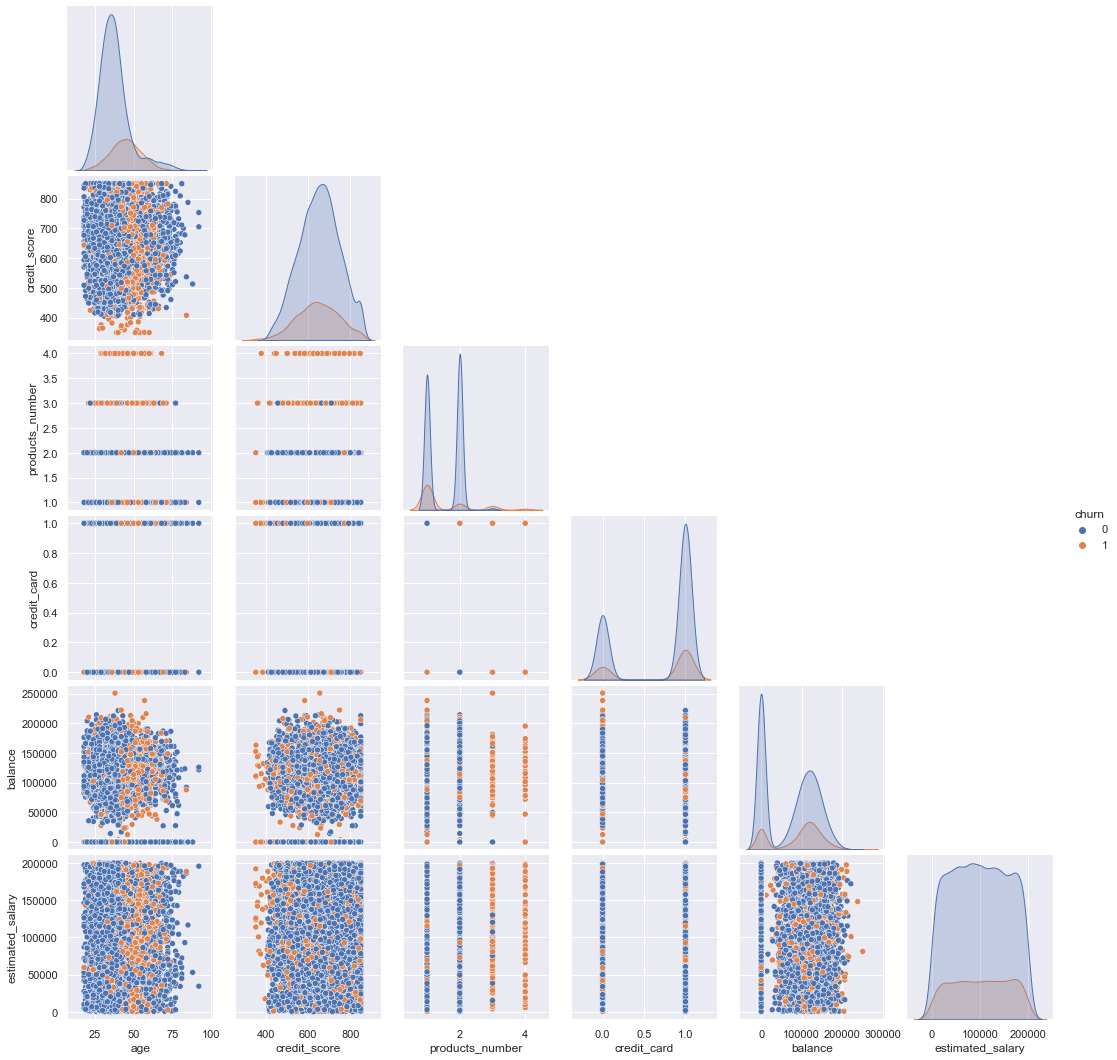

In [24]:
sns.set_theme()
plt.figure(figsize=(20,15))
sns.pairplot(data=df[["age","credit_score","products_number","credit_card","balance",'estimated_salary',"churn"]],hue='churn',corner=True)
plt.show()


#  Model Building
## Split data

In [25]:
features = list(dfNum.columns)
target = "churn"
features.remove(target)

X = dfNum[features]
y = dfNum[target]

In [26]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(7000, 12)
(3000, 12)


## Random Forest

In [27]:
steps = [('rescale', StandardScaler()),
         ('ranFo', RandomForestClassifier(n_estimators=1000,random_state=20))]
modelRf = Pipeline(steps)
modelRf = modelRf.fit(X_train, y_train)
Rfpred = modelRf.predict(X_test)


In [29]:
cf_matrixRf = confusion_matrix(y_test,Rfpred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrixRf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrixRf.flatten()/np.sum(cf_matrixRf)]


Text(0.5, 1.0, 'Accuracy Score: 0.8623333333333333')

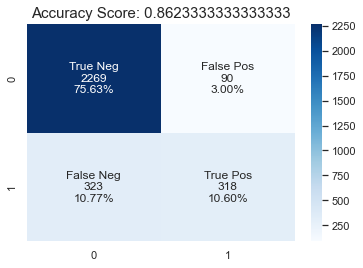

In [30]:
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrixRf, annot = labels, fmt = '', cmap = 'Blues')
all_sample_title = 'Accuracy Score: {0}'.format(modelRf.score(X_test, y_test))
plt.title(all_sample_title, size = 15)


## Logistic regression

In [32]:
steps = [('rescale', StandardScaler()),
         ('logr', LogisticRegression())]
modelLr = Pipeline(steps)
modelLr = modelLr.fit(X_train, y_train)
y_train_pred = modelLr.predict(X_train)
LRpred = modelLr.predict(X_test)


In [33]:
cf_matrixLr = confusion_matrix(y_test,LRpred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrixLr.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrixLr.flatten()/np.sum(cf_matrixLr)]


Text(0.5, 1.0, 'Accuracy Score: 0.809')

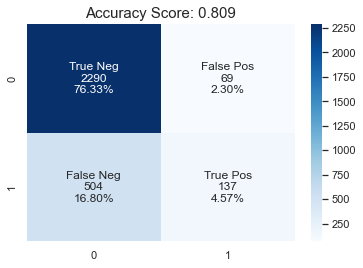

In [34]:
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrixLr, annot = labels, fmt = '', cmap = 'Blues')
all_sample_title = 'Accuracy Score: {0}'.format(modelLr.score(X_test, y_test))
plt.title(all_sample_title, size = 15)


## Support Vector Machine

In [35]:
steps = [('rescale', StandardScaler()),
         ('svm', DecisionTreeClassifier())]
svm = Pipeline(steps)
svm.fit(X_train, y_train)

y_train_pred = svm.predict(X_train)
SVMpred = svm.predict(X_test)


In [37]:
cf_matrixLr = confusion_matrix(y_test,SVMpred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrixLr.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrixLr.flatten()/np.sum(cf_matrixLr)]


Text(0.5, 1.0, 'Accuracy Score: 0.7903333333333333')

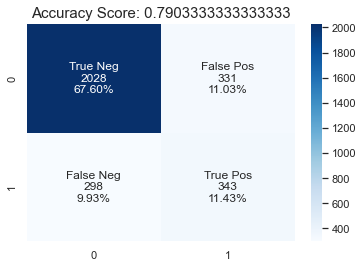

In [38]:
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrixLr, annot = labels, fmt = '', cmap = 'Blues')
all_sample_title = 'Accuracy Score: {0}'.format(svm.score(X_test, y_test))
plt.title(all_sample_title, size = 15)


## XGB

In [39]:
steps = [('rescale', StandardScaler()),
         ('sgboost', GradientBoostingClassifier())]
xgb_model = Pipeline(steps)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
XGBpred = xgb_model.predict(X_test)


In [41]:
cf_matrixLr = confusion_matrix(y_test,XGBpred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrixLr.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrixLr.flatten()/np.sum(cf_matrixLr)]


Text(0.5, 1.0, 'Accuracy Score: 0.863')

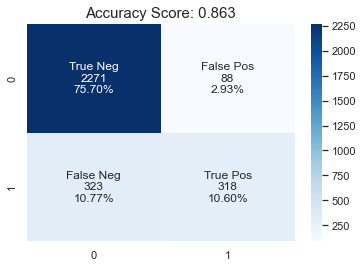

In [42]:
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrixLr, annot = labels, fmt = '', cmap = 'Blues')
all_sample_title = 'Accuracy Score: {0}'.format(xgb_model.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

## ROC Random forest

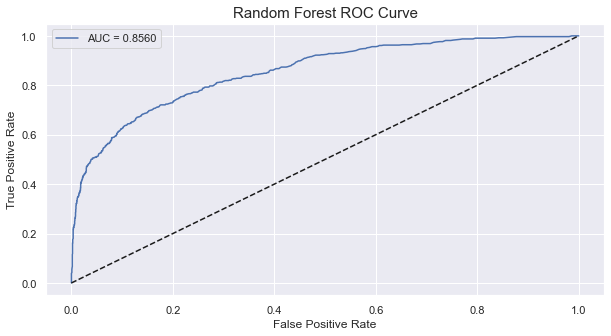

In [43]:
plt.figure(figsize=(10,5))
y_pred_proba = modelRf.predict_proba(X_test)[:][:,1]
df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve', size = 15)
plt.legend()

## ROC XGB

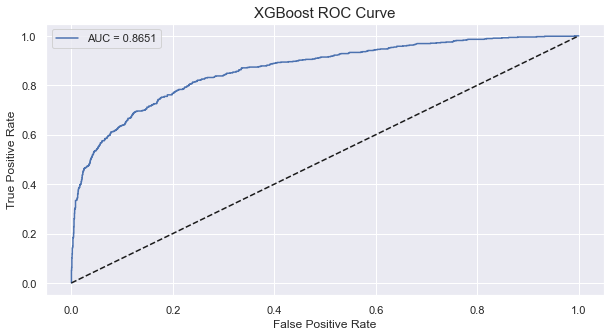

In [44]:
plt.figure(figsize=(10,5))
y_pred_proba = xgb_model.predict_proba(X_test)[:][:,1]
df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve', size = 15)
plt.legend()

In [51]:
print(classification_report(y_test,Rfpred))
print(classification_report(y_test,LRpred))
print(classification_report(y_test,SVMpred))
print(classification_report(y_test,XGBpred))


              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2359
           1       0.78      0.50      0.61       641

    accuracy                           0.86      3000
   macro avg       0.83      0.73      0.76      3000
weighted avg       0.85      0.86      0.85      3000

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      2359
           1       0.67      0.21      0.32       641

    accuracy                           0.81      3000
   macro avg       0.74      0.59      0.61      3000
weighted avg       0.79      0.81      0.77      3000

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2359
           1       0.51      0.54      0.52       641

    accuracy                           0.79      3000
   macro avg       0.69      0.70      0.69      3000
weighted avg       0.79      0.79      0.79      3000

              preci

# Suggestions to improve

#### 1 Use the churn prediction model as a reference for banks to identify the customers who are likely to churn
#### 2 Improve the competitiveness of services for females and middle-aged customers. Suggest to get more data from the marketing department to analyse the possible reasons.
#### 3 Provide diversity in membership activities as increasing user engagement can reduce customer churn.
